# **1. LIBRARY**

In [1]:
!pip install keras_unet_collection

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.0 MB/s eta 0:00:00


In [2]:
import os
import pickle
import random
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import keras
import time
import keras_unet_collection
from tqdm import tqdm
from keras.optimizers import Adam
from keras_unet_collection import models
from keras.callbacks import EarlyStopping
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [3]:
def random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    keras.utils.set_random_seed(seed)

# **2. DATASET**

In [4]:
img_size = 128

In [5]:
x_train = np.load('/kaggle/input/dermoscopic-lesion/train/images.npy')
y_train = (np.load('/kaggle/input/dermoscopic-lesion/train/masks.npy') >= 0.5).astype(np.float32)
x_val = np.load('/kaggle/input/dermoscopic-lesion/val/images.npy')
y_val = (np.load('/kaggle/input/dermoscopic-lesion/val/masks.npy') >= 0.5).astype(np.float32)

print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_val))
print(np.shape(y_val))

(2074, 128, 128, 3)
(2074, 128, 128, 1)
(260, 128, 128, 3)
(260, 128, 128, 1)


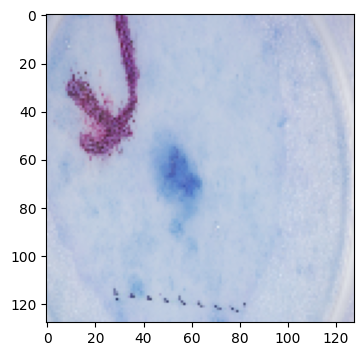

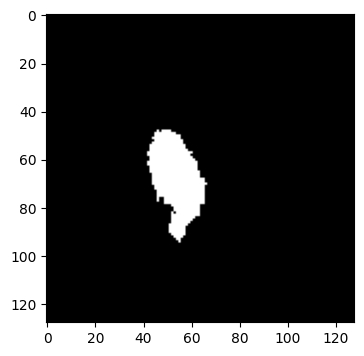

In [6]:
plt.figure(figsize=(4, 4))
plt.imshow(x_train[0], cmap='gray')
plt.show()

plt.figure(figsize=(4, 4))
plt.imshow(y_train[0], cmap='gray')
plt.show()

# **3. METRIC**

In [7]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred_bin = K.cast((y_pred >= 0.5), tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred_bin), axis=[1])
    combination = K.sum(y_true, [1]) + K.sum(y_pred_bin, [1])
    dice = K.mean((intersection + intersection + smooth) / (combination + smooth), axis=0)
    return dice

In [8]:
def iou_coef(y_true, y_pred, smooth=1):
    y_pred_bin = K.cast((y_pred >= 0.5), tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred_bin), axis=[1])
    union = K.sum(y_true, [1]) + K.sum(y_pred_bin, [1]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# **4. TRAINING**

## **4.1. Custom Fit**

In [9]:
history_train_dice, history_train_iou, history_train_loss = [], [], []
history_val_dice, history_val_iou, history_val_loss = [], [], []

def custom_fit(model, x_train, y_train, x_val, y_val, epochs, batch_size):
    weights = []
    
    excution_time = 0
    num_train_samples = np.shape(x_train)[0]
    num_val_samples = np.shape(x_val)[0]

    for epoch in range(epochs):
        print('\033[1mEpoch {}/{}\033[0m'.format(epoch + 1, epochs))

        train_dice, train_iou, train_loss = 0.0, 0.0, 0.0
        start_time = time.time()
        for i in tqdm(range(0, num_train_samples, batch_size)):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            metrics = model.fit(x=x_batch, y=y_batch, batch_size=batch_size, epochs=1, verbose=False).history
            dice = metrics.get('dice_coef')[0]
            iou = metrics.get('iou_coef')[0]
            loss = metrics.get('loss')[0]

            train_dice += dice * np.shape(x_batch)[0]
            train_iou += iou * np.shape(x_batch)[0]
            train_loss += loss * np.shape(x_batch)[0]
        end_time = time.time()

        train_dice /= num_train_samples
        train_iou /= num_train_samples
        train_loss /= num_train_samples
        print('   train_dice_coef: {} - train_iou_coef: {} - train_loss: {}'.format(round(train_dice, 4), round(train_iou, 4), round(train_loss, 4)))
        history_train_dice.append(train_dice)
        history_train_iou.append(train_iou)
        history_train_loss.append(train_loss)
        
        metrics = model.evaluate(x_val, y_val, batch_size=batch_size, return_dict=True, verbose=False)
        val_dice = metrics['dice_coef']
        val_iou = metrics['iou_coef']
        val_loss = metrics['loss']

        print('   val_dice_coef: {} - val_iou_coef: {} - val_loss: {}'.format(round(val_dice, 4), round(val_iou, 4), round(val_loss, 4)))
        history_val_dice.append(val_dice)
        history_val_iou.append(val_iou)
        history_val_loss.append(val_loss)

        excution_time_epoch = int(end_time - start_time)
        excution_time += excution_time_epoch
        print('   time: {}s\n'.format(excution_time_epoch))

        weights.append(model.get_weights())

    print('Training excution time: {}s\n'.format(excution_time))

    return weights

## **4.2. Model Training**

In [10]:
random_seed(42)

r2unet = models.r2_unet_2d(
    input_size=(img_size, img_size, 3), 
    filter_num=[16, 32, 64, 128, 256], 
    n_labels=1,
    stack_num_down=2,
    stack_num_up=2,
    activation='ReLU',
    recur_num=2,
    output_activation='Sigmoid', 
    pool='max'
)

r2unet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[dice_coef, iou_coef])

r2unet.summary()

Model: "r2_unet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ r2_unet_input             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv        │ (None, 128, 128, 16)   │             64 │ r2_unet_input[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv0       │ (None, 128, 128, 16)   │          2,320 │ r2_unet_down0_conv[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_activation0 │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_conv0[0… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_add0_0      │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_activat… │
│ (Add)                     │                        │                │ r2_unet_down0_conv[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv0_0     │ (None, 128, 128, 16)   │          2,320 │ r2_unet_down0_add0_0[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_activation… │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_conv0_0… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_add0_1      │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_activat… │
│ (Add)                     │                        │                │ r2_unet_down0_conv[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv0_1     │ (None, 128, 128, 16)   │          2,320 │ r2_unet_down0_add0_1[… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_activation… │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_conv0_1… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_conv1       │ (None, 128, 128, 16)   │          2,320 │ r2_unet_down0_activat… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_activation1 │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_conv1[0… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2_unet_down0_add1_0      │ (None, 128, 128, 16)   │              0 │ r2_unet_down0_activat… │
│ (Add)                     │                        │                │ r2_unet_down0_activat… │
├──────────────────────

 Total params: 6,373,201 (24.31 MB)

 Trainable params: 6,373,201 (24.31 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
weights_r2unet = custom_fit(r2unet, x_train, y_train, x_val, y_val, epochs=50, batch_size=128)

Epoch 1/50


100%|██████████| 17/17 [01:08<00:00,  4.00s/it]


   train_dice_coef: 0.5884 - train_iou_coef: 0.5685 - train_loss: 0.4374
   val_dice_coef: 0.6241 - val_iou_coef: 0.5749 - val_loss: 0.4156
   time: 68s

Epoch 2/50


100%|██████████| 17/17 [00:08<00:00,  2.06it/s]


   train_dice_coef: 0.775 - train_iou_coef: 0.7432 - train_loss: 0.3187
   val_dice_coef: 0.7727 - val_iou_coef: 0.7296 - val_loss: 0.2791
   time: 8s

Epoch 3/50


100%|██████████| 17/17 [00:08<00:00,  2.06it/s]


   train_dice_coef: 0.8107 - train_iou_coef: 0.7802 - train_loss: 0.2741
   val_dice_coef: 0.8184 - val_iou_coef: 0.7815 - val_loss: 0.2332
   time: 8s

Epoch 4/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.8354 - train_iou_coef: 0.8043 - train_loss: 0.2355
   val_dice_coef: 0.8063 - val_iou_coef: 0.7673 - val_loss: 0.2391
   time: 8s

Epoch 5/50


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


   train_dice_coef: 0.8449 - train_iou_coef: 0.8146 - train_loss: 0.2203
   val_dice_coef: 0.8288 - val_iou_coef: 0.7909 - val_loss: 0.2062
   time: 8s

Epoch 6/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.8553 - train_iou_coef: 0.8252 - train_loss: 0.2038
   val_dice_coef: 0.8285 - val_iou_coef: 0.7906 - val_loss: 0.2052
   time: 8s

Epoch 7/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.8654 - train_iou_coef: 0.8358 - train_loss: 0.1895
   val_dice_coef: 0.8435 - val_iou_coef: 0.8074 - val_loss: 0.189
   time: 8s

Epoch 8/50


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


   train_dice_coef: 0.8734 - train_iou_coef: 0.8445 - train_loss: 0.1767
   val_dice_coef: 0.8504 - val_iou_coef: 0.8146 - val_loss: 0.1722
   time: 8s

Epoch 9/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.8773 - train_iou_coef: 0.8488 - train_loss: 0.1698
   val_dice_coef: 0.862 - val_iou_coef: 0.8271 - val_loss: 0.157
   time: 8s

Epoch 10/50


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


   train_dice_coef: 0.8815 - train_iou_coef: 0.8533 - train_loss: 0.163
   val_dice_coef: 0.8669 - val_iou_coef: 0.8327 - val_loss: 0.1496
   time: 8s

Epoch 11/50


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


   train_dice_coef: 0.8843 - train_iou_coef: 0.8566 - train_loss: 0.1582
   val_dice_coef: 0.8733 - val_iou_coef: 0.8402 - val_loss: 0.1422
   time: 8s

Epoch 12/50


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


   train_dice_coef: 0.887 - train_iou_coef: 0.8596 - train_loss: 0.1529
   val_dice_coef: 0.872 - val_iou_coef: 0.839 - val_loss: 0.144
   time: 8s

Epoch 13/50


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


   train_dice_coef: 0.891 - train_iou_coef: 0.8639 - train_loss: 0.1457
   val_dice_coef: 0.8833 - val_iou_coef: 0.8518 - val_loss: 0.1263
   time: 8s

Epoch 14/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.8953 - train_iou_coef: 0.8686 - train_loss: 0.1401
   val_dice_coef: 0.8744 - val_iou_coef: 0.8408 - val_loss: 0.142
   time: 8s

Epoch 15/50


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


   train_dice_coef: 0.8943 - train_iou_coef: 0.8675 - train_loss: 0.1416
   val_dice_coef: 0.875 - val_iou_coef: 0.8419 - val_loss: 0.1468
   time: 8s

Epoch 16/50


100%|██████████| 17/17 [00:08<00:00,  2.01it/s]


   train_dice_coef: 0.8965 - train_iou_coef: 0.87 - train_loss: 0.1393
   val_dice_coef: 0.8918 - val_iou_coef: 0.8631 - val_loss: 0.1165
   time: 8s

Epoch 17/50


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


   train_dice_coef: 0.9042 - train_iou_coef: 0.8786 - train_loss: 0.1278
   val_dice_coef: 0.8903 - val_iou_coef: 0.8594 - val_loss: 0.1209
   time: 8s

Epoch 18/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.9034 - train_iou_coef: 0.8776 - train_loss: 0.1266
   val_dice_coef: 0.8928 - val_iou_coef: 0.8624 - val_loss: 0.1147
   time: 8s

Epoch 19/50


100%|██████████| 17/17 [00:08<00:00,  2.00it/s]


   train_dice_coef: 0.9065 - train_iou_coef: 0.8812 - train_loss: 0.1214
   val_dice_coef: 0.895 - val_iou_coef: 0.866 - val_loss: 0.1116
   time: 8s

Epoch 20/50


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


   train_dice_coef: 0.9102 - train_iou_coef: 0.8854 - train_loss: 0.115
   val_dice_coef: 0.8868 - val_iou_coef: 0.8565 - val_loss: 0.1161
   time: 8s

Epoch 21/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.9124 - train_iou_coef: 0.8877 - train_loss: 0.1119
   val_dice_coef: 0.8794 - val_iou_coef: 0.8488 - val_loss: 0.1212
   time: 8s

Epoch 22/50


100%|██████████| 17/17 [00:08<00:00,  2.00it/s]


   train_dice_coef: 0.911 - train_iou_coef: 0.8862 - train_loss: 0.1137
   val_dice_coef: 0.8742 - val_iou_coef: 0.8446 - val_loss: 0.1223
   time: 8s

Epoch 23/50


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


   train_dice_coef: 0.9127 - train_iou_coef: 0.8882 - train_loss: 0.1093
   val_dice_coef: 0.8906 - val_iou_coef: 0.8603 - val_loss: 0.1083
   time: 8s

Epoch 24/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.915 - train_iou_coef: 0.8907 - train_loss: 0.1044
   val_dice_coef: 0.8946 - val_iou_coef: 0.8633 - val_loss: 0.1149
   time: 8s

Epoch 25/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.9116 - train_iou_coef: 0.8868 - train_loss: 0.1095
   val_dice_coef: 0.8845 - val_iou_coef: 0.8527 - val_loss: 0.1474
   time: 8s

Epoch 26/50


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


   train_dice_coef: 0.9032 - train_iou_coef: 0.8775 - train_loss: 0.1255
   val_dice_coef: 0.8892 - val_iou_coef: 0.8603 - val_loss: 0.1339
   time: 8s

Epoch 27/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.9071 - train_iou_coef: 0.8817 - train_loss: 0.1196
   val_dice_coef: 0.8917 - val_iou_coef: 0.8606 - val_loss: 0.1137
   time: 8s

Epoch 28/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.9104 - train_iou_coef: 0.8852 - train_loss: 0.1135
   val_dice_coef: 0.8978 - val_iou_coef: 0.8693 - val_loss: 0.1116
   time: 8s

Epoch 29/50


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


   train_dice_coef: 0.9177 - train_iou_coef: 0.8935 - train_loss: 0.1026
   val_dice_coef: 0.892 - val_iou_coef: 0.8599 - val_loss: 0.1099
   time: 8s

Epoch 30/50


100%|██████████| 17/17 [00:08<00:00,  2.11it/s]


   train_dice_coef: 0.9209 - train_iou_coef: 0.8971 - train_loss: 0.094
   val_dice_coef: 0.886 - val_iou_coef: 0.8538 - val_loss: 0.1137
   time: 8s

Epoch 31/50


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


   train_dice_coef: 0.9219 - train_iou_coef: 0.8984 - train_loss: 0.0918
   val_dice_coef: 0.8829 - val_iou_coef: 0.8512 - val_loss: 0.1182
   time: 8s

Epoch 32/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.9223 - train_iou_coef: 0.8987 - train_loss: 0.0925
   val_dice_coef: 0.8868 - val_iou_coef: 0.8568 - val_loss: 0.109
   time: 8s

Epoch 33/50


100%|██████████| 17/17 [00:08<00:00,  1.97it/s]


   train_dice_coef: 0.9188 - train_iou_coef: 0.8951 - train_loss: 0.0978
   val_dice_coef: 0.8787 - val_iou_coef: 0.8501 - val_loss: 0.1288
   time: 8s

Epoch 34/50


100%|██████████| 17/17 [00:08<00:00,  2.06it/s]


   train_dice_coef: 0.9233 - train_iou_coef: 0.8997 - train_loss: 0.0895
   val_dice_coef: 0.8896 - val_iou_coef: 0.8614 - val_loss: 0.1152
   time: 8s

Epoch 35/50


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


   train_dice_coef: 0.9299 - train_iou_coef: 0.9075 - train_loss: 0.0779
   val_dice_coef: 0.8855 - val_iou_coef: 0.8564 - val_loss: 0.116
   time: 8s

Epoch 36/50


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


   train_dice_coef: 0.9321 - train_iou_coef: 0.91 - train_loss: 0.075
   val_dice_coef: 0.8767 - val_iou_coef: 0.8477 - val_loss: 0.1316
   time: 8s

Epoch 37/50


100%|██████████| 17/17 [00:08<00:00,  2.04it/s]


   train_dice_coef: 0.9282 - train_iou_coef: 0.9056 - train_loss: 0.0806
   val_dice_coef: 0.8776 - val_iou_coef: 0.8495 - val_loss: 0.1248
   time: 8s

Epoch 38/50


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


   train_dice_coef: 0.9303 - train_iou_coef: 0.9078 - train_loss: 0.0784
   val_dice_coef: 0.8813 - val_iou_coef: 0.8512 - val_loss: 0.1243
   time: 8s

Epoch 39/50


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


   train_dice_coef: 0.9205 - train_iou_coef: 0.8971 - train_loss: 0.0918
   val_dice_coef: 0.8828 - val_iou_coef: 0.8485 - val_loss: 0.1304
   time: 8s

Epoch 40/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.9258 - train_iou_coef: 0.9028 - train_loss: 0.0873
   val_dice_coef: 0.8993 - val_iou_coef: 0.8701 - val_loss: 0.1146
   time: 8s

Epoch 41/50


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


   train_dice_coef: 0.9325 - train_iou_coef: 0.9104 - train_loss: 0.0749
   val_dice_coef: 0.8942 - val_iou_coef: 0.8633 - val_loss: 0.1263
   time: 8s

Epoch 42/50


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


   train_dice_coef: 0.9332 - train_iou_coef: 0.9113 - train_loss: 0.0726
   val_dice_coef: 0.8848 - val_iou_coef: 0.8506 - val_loss: 0.1288
   time: 8s

Epoch 43/50


100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


   train_dice_coef: 0.9291 - train_iou_coef: 0.9066 - train_loss: 0.0795
   val_dice_coef: 0.8856 - val_iou_coef: 0.8572 - val_loss: 0.1226
   time: 8s

Epoch 44/50


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


   train_dice_coef: 0.9217 - train_iou_coef: 0.8979 - train_loss: 0.0921
   val_dice_coef: 0.8886 - val_iou_coef: 0.8606 - val_loss: 0.1136
   time: 8s

Epoch 45/50


100%|██████████| 17/17 [00:08<00:00,  2.03it/s]


   train_dice_coef: 0.9217 - train_iou_coef: 0.8981 - train_loss: 0.0905
   val_dice_coef: 0.8932 - val_iou_coef: 0.8638 - val_loss: 0.13
   time: 8s

Epoch 46/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.9329 - train_iou_coef: 0.911 - train_loss: 0.0744
   val_dice_coef: 0.8979 - val_iou_coef: 0.8711 - val_loss: 0.1192
   time: 8s

Epoch 47/50


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


   train_dice_coef: 0.9361 - train_iou_coef: 0.9147 - train_loss: 0.0683
   val_dice_coef: 0.8886 - val_iou_coef: 0.8593 - val_loss: 0.1198
   time: 8s

Epoch 48/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.9371 - train_iou_coef: 0.9157 - train_loss: 0.0672
   val_dice_coef: 0.8846 - val_iou_coef: 0.8558 - val_loss: 0.1359
   time: 8s

Epoch 49/50


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


   train_dice_coef: 0.9361 - train_iou_coef: 0.9145 - train_loss: 0.0684
   val_dice_coef: 0.8737 - val_iou_coef: 0.8449 - val_loss: 0.1582
   time: 8s

Epoch 50/50


100%|██████████| 17/17 [00:08<00:00,  2.07it/s]


   train_dice_coef: 0.9321 - train_iou_coef: 0.9101 - train_loss: 0.0753
   val_dice_coef: 0.8888 - val_iou_coef: 0.8589 - val_loss: 0.1152
   time: 8s

Training excution time: 460s



## **4.3. Saving**

In [12]:
os.makedirs('model', exist_ok=True)
r2unet.save('model/R2U-Net.h5')
with open('model/weights.pkl', 'wb') as f:
    pickle.dump(weights_r2unet, f)

os.makedirs('history', exist_ok=True)
with open('history/train_loss.pkl', 'wb') as f:
    pickle.dump(np.array(history_train_loss), f)
with open('history/train_dice.pkl', 'wb') as f:
    pickle.dump(np.array(history_train_dice), f)
with open('history/train_iou.pkl', 'wb') as f:
    pickle.dump(np.array(history_train_iou), f)
with open('history/val_loss.pkl', 'wb') as f:
    pickle.dump(np.array(history_val_loss), f)
with open('history/val_dice.pkl', 'wb') as f:
    pickle.dump(np.array(history_val_dice), f)
with open('history/val_iou.pkl', 'wb') as f:
    pickle.dump(np.array(history_val_iou), f)